In [2]:
#!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)

In [3]:
df = pd.read_csv("smoking.csv")


In [4]:
df.drop(columns=['ID'], inplace=True)

categorical_columns = []
numerical_columns = []

for col in df.columns[:-1]:
    if df[col].dtype == 'object' or col in ['hearing(left)', 'hearing(right)']:
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

for col in ['gender', 'oral', 'tartar']:
    df[col] = LabelEncoder().fit_transform(df[col])

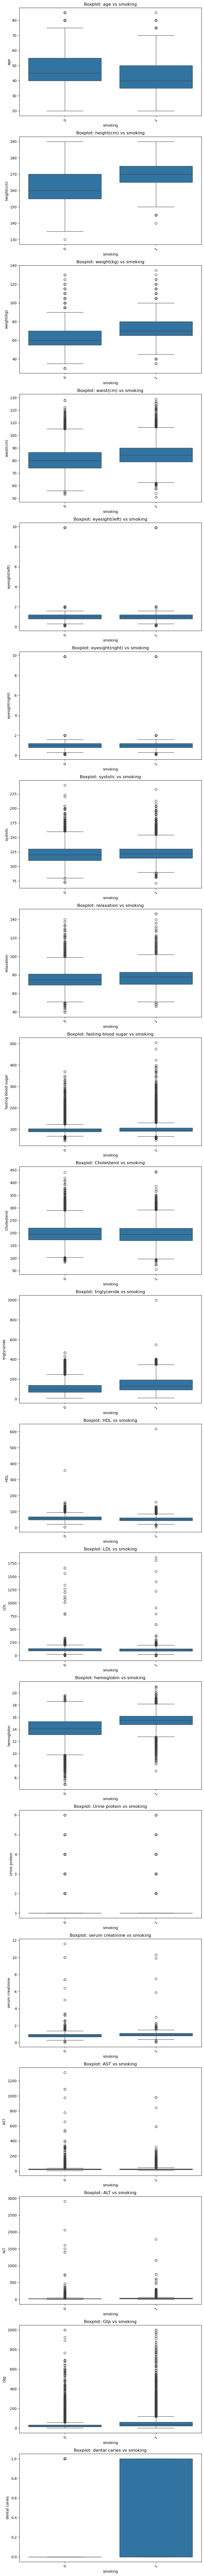

In [5]:
# ===================== Boxplots (Numerical) =====================
target_column = df.columns[-1]   # Define target column automatically

plt.figure(figsize=(8, 5 * len(numerical_columns)))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data=df, x=target_column, y=col)
    plt.title(f'Boxplot: {col} vs {target_column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


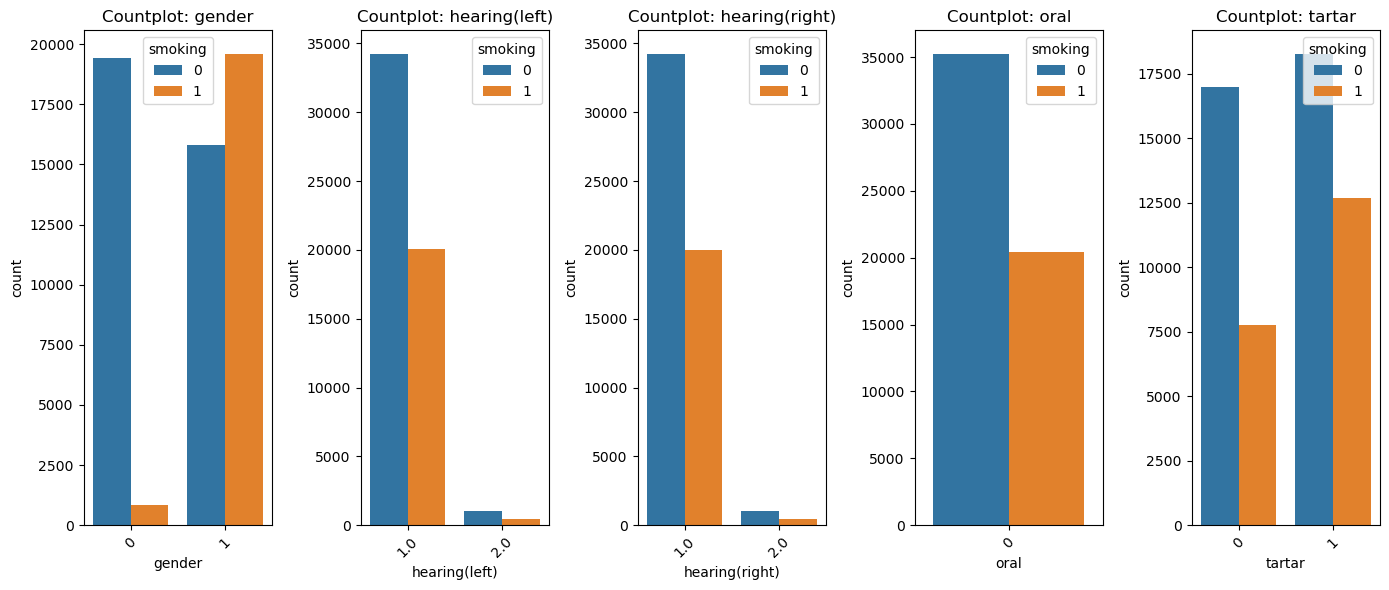

In [6]:
plt.figure(figsize=(14, 6))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(1, len(categorical_columns), i)
    sns.countplot(data=df, x=col, hue=target_column)
    plt.title(f'Countplot: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
df_clean = df.copy()
for col in numerical_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

In [8]:
X = df_clean.drop(columns=['smoking'])
Y = df_clean['smoking']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [9]:
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, Y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]
acc_log = accuracy_score(Y_test, y_pred_log)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(Y_test, y_pred_rf)

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, Y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
acc_xgb = accuracy_score(Y_test, y_pred_xgb)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, Y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]
acc_dt = accuracy_score(Y_test, y_pred_dt)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
print(f"Logistic Regression Accuracy = {acc_log * 100:.2f}%")
print(f"Random Forest Accuracy = {acc_rf * 100:.2f}%")
print(f"XGBoost Accuracy = {acc_xgb * 100:.2f}%")
print(f"Decision Tree Accuracy = {acc_dt * 100:.2f}%")

Logistic Regression Accuracy = 74.67%
Random Forest Accuracy = 82.95%
XGBoost Accuracy = 79.88%
Decision Tree Accuracy = 77.70%


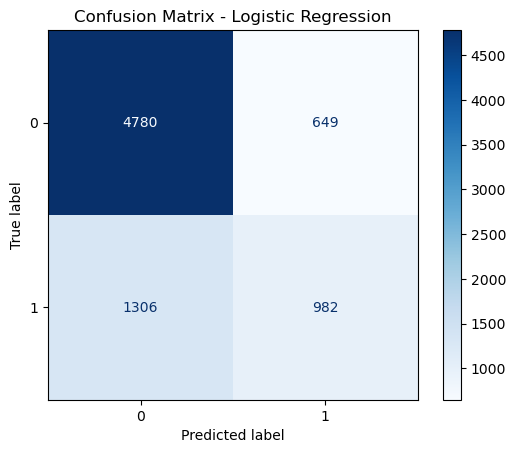

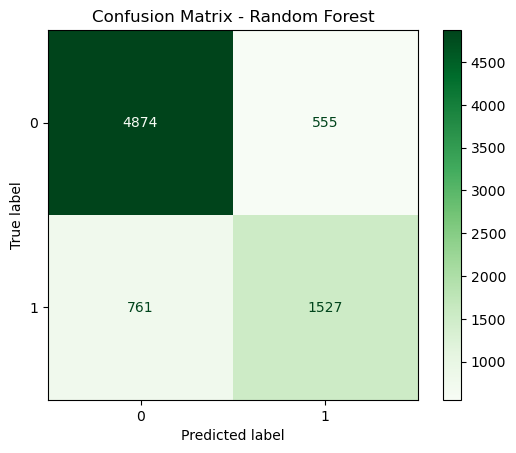

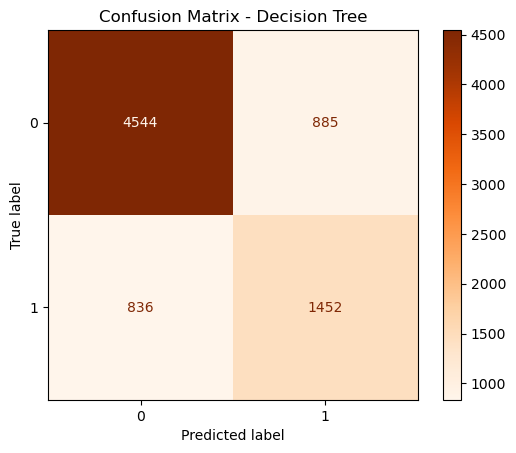

In [11]:
models = {
    "Logistic Regression": (y_pred_log, "Blues"),
    "Random Forest": (y_pred_rf, "Greens"),
    "Decision Tree": (y_pred_dt, "Oranges"),
}

for name, (y_pred, color) in models.items():
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=color)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


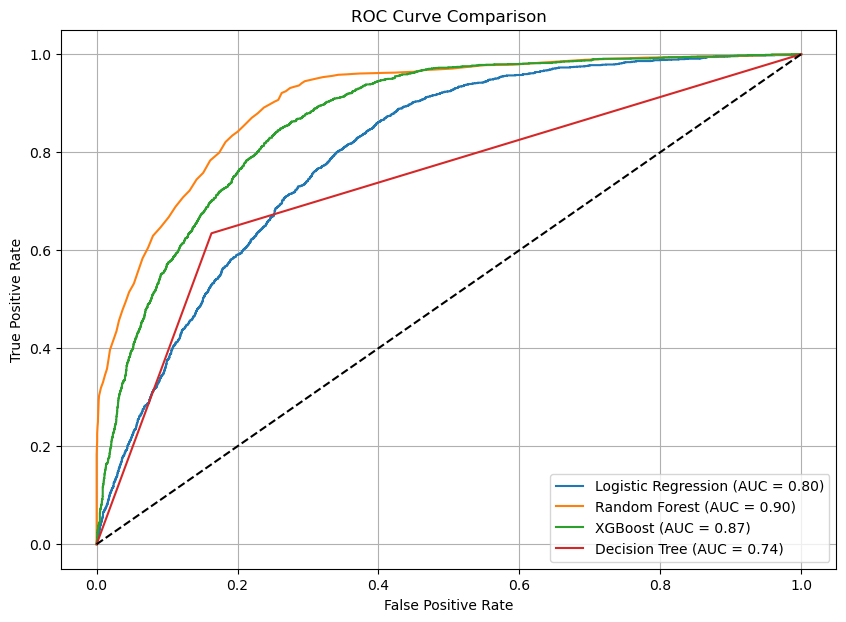

In [12]:
plt.figure(figsize=(10, 7))

fpr_log, tpr_log, _ = roc_curve(Y_test, y_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [13]:
# ===================== Manual Input Test =====================
# Sample test input (provide values in the same order as the features in X)
# You can change these values to test with different data points

sample_data = {
    'age': 30,
    'height(cm)': 170,
    'weight(kg)': 65,
    'waist(cm)': 80,
    'eyesight(left)': 1.0,
    'eyesight(right)': 1.0,
    'hearing(left)': 1,
    'hearing(right)': 1,
    'systolic': 120,
    'relaxation': 80,
    'fasting blood sugar': 90,
    'Cholesterol': 180,
    'HDL': 50,
    'LDL': 100,
    'triglyceride': 150, # Added missing column
    'hemoglobin': 14,
    'Urine protein': 1,
    'serum creatinine': 0.9,
    'AST': 25,
    'ALT': 20,
    'Gtp': 30,
    'gender': 1,   # (1 = Male, 0 = Female)
    'oral': 0,     # (0 = No, 1 = Yes)
    'dental caries': 0, # Added missing column
    'tartar': 1    # (0 = No, 1 = Yes)
}

# Convert to DataFrame and match feature order
test_df = pd.DataFrame([sample_data])[X.columns]

# Predict using all trained models
print("Predictions on sample input:")
print(f"Logistic Regression: {'Smoker' if log_model.predict(test_df)[0] == 1 else 'Non-Smoker'}")
print(f"Random Forest: {'Smoker' if rf_model.predict(test_df)[0] == 1 else 'Non-Smoker'}")
print(f"XGBoost: {'Smoker' if xgb_model.predict(test_df)[0] == 1 else 'Non-Smoker'}")
print(f"Decision Tree: {'Smoker' if dt_model.predict(test_df)[0] == 1 else 'Non-Smoker'}")

Predictions on sample input:
Logistic Regression: Non-Smoker
Random Forest: Smoker
XGBoost: Smoker
Decision Tree: Smoker


In [14]:
import joblib

# Save trained models
joblib.dump(log_model, "logistic_regression.pkl")
joblib.dump(dt_model, "decision_tree.pkl")
joblib.dump(rf_model, "random_forest.pkl")
joblib.dump(xgb_model, "xgboost.pkl")

print("✅ All models saved successfully!")


✅ All models saved successfully!


In [15]:


# Save feature names used during training
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")

print("✅ Feature names saved successfully!")


✅ Feature names saved successfully!
